# 

# Process

## 0. Setup

In [1]:
import os, sys
import shutil
import math
import time
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import voxelmorph as vxm
import neurite as ne

In [2]:
# PATH Setting
DIR_PATH = 'F:/20210730_samples'
DATA_PATH = os.path.join(DIR_PATH, 'nifty')
SAVE_PATH = os.path.join(DIR_PATH, 'numpy')

## 1. Preprocessing

In [3]:
from utils.preprocessing.nifty_preprocessing import nif2npy
nif2npy(PATH=DIR_PATH)

Numpy Processing:   0%|          | 0/16 [00:00<?, ?it/s]

In [71]:
# load CT, PT Voxels
CT_PATH = os.path.join(SAVE_PATH, 'CT_target')
PT_PATH = os.path.join(SAVE_PATH, 'PT_resize')
CT_list = os.listdir(CT_PATH)
PT_list = os.listdir(PT_PATH)

sample_num = len(os.listdir(CT_PATH)) # extract sample #
vol_shape = np.load(os.path.join(CT_PATH, CT_list[0])).shape # extract data shape
CT_input = np.zeros([sample_num, *vol_shape])
PT_input = np.zeros([sample_num, *vol_shape])

for i in range(sample_num):
    CT_input[i] = np.load(os.path.join(CT_PATH, CT_list[i]))
    PT_input[i] = np.load(os.path.join(PT_PATH, PT_list[i]))

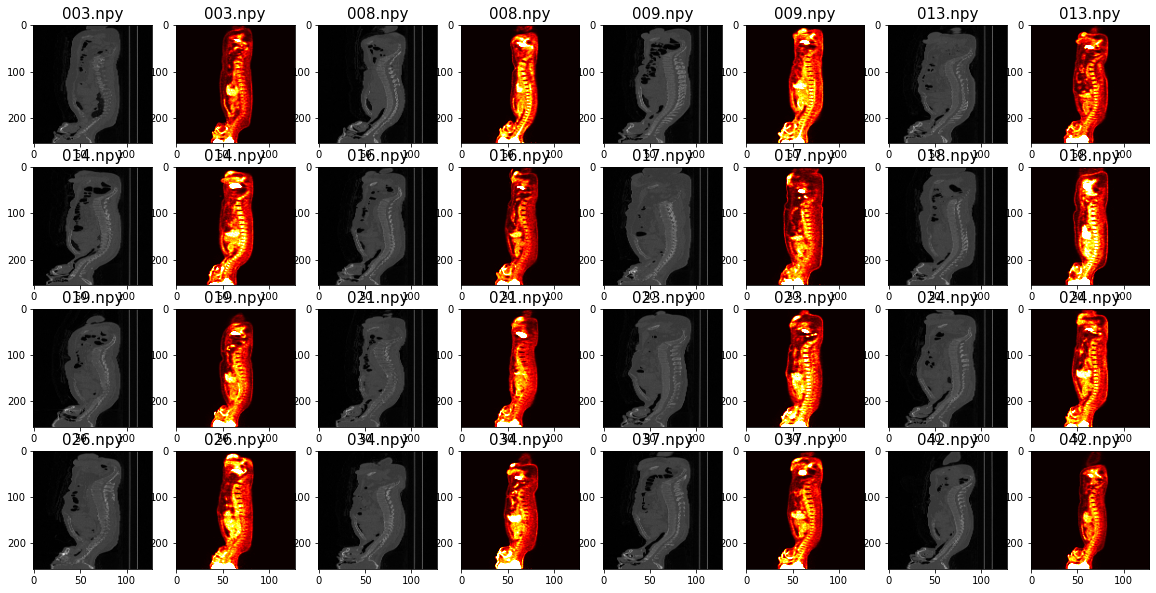

In [6]:
# Check (Vanilla)
from utils.common.plot import compare_plot
CT_PATH = os.path.join(SAVE_PATH, 'CT_target')
PT_PATH = os.path.join(SAVE_PATH, 'PT_vanilla')
fig = plt.figure(figsize=(20,10))
compare_plot(PATH_1=CT_PATH, PATH_2=PT_PATH, fig=fig, grid=(4,8), vmax=[1, 0.01])

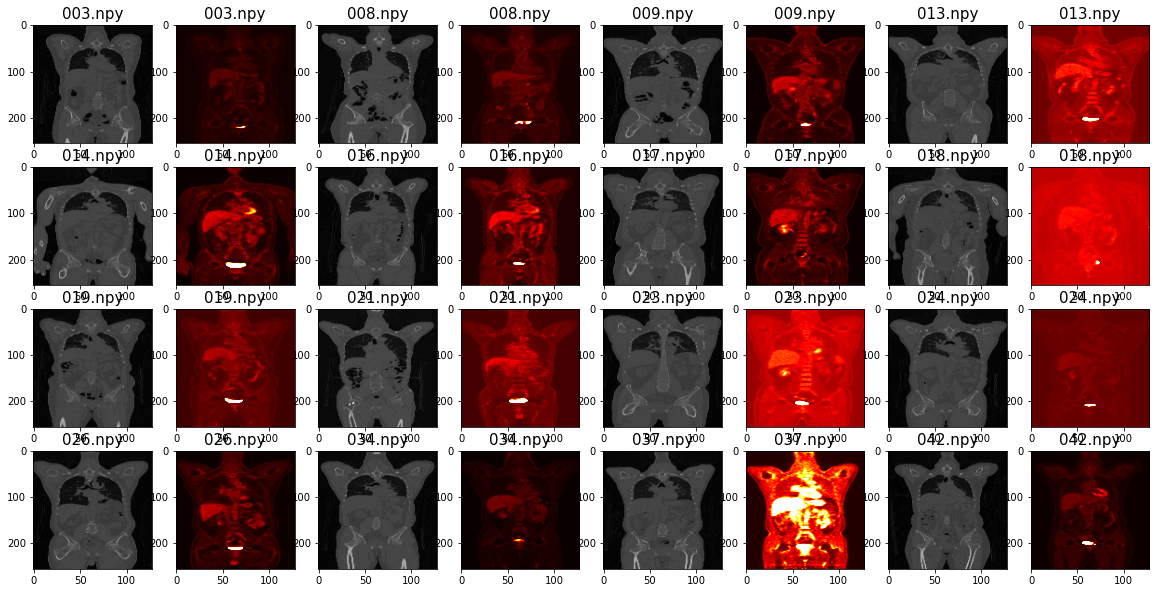

In [6]:
# Check (Resize)
CT_PATH = os.path.join(SAVE_PATH, 'CT_target')
PT_PATH = os.path.join(SAVE_PATH, 'PT_resize')
fig = plt.figure(figsize=(20,10))
compare_plot(PATH_1=CT_PATH, PATH_2=PT_PATH, fig=fig, grid=(4,8), vmax=[1, 0.1])

## 2. VoxelMorph Baseline

In [4]:
# Data Generator Function
def vxm_data_generator(PATH_1, PATH_2, batch_size=32, shuffle=True):
    # Data : [M, X, Y, Z]
    
    # Generation
    # Input : moving-img [N, X, Y, Z, 1], fixed-img [N, X, Y, Z, 1]
    # Output : moved-img [N, X, Y, Z, 1], zero-grad [N, X, Y, Z, 3]
    PATH_1_list = os.listdir(PATH_1)
    PATH_2_list = os.listdir(PATH_2)
    
    # preliminary sizing
    sample_num = len(os.listdir(PATH_1)) # extract sample #
    vol_shape = np.load(os.path.join(PATH_1, PATH_1_list[0])).shape # extract data shape
    CT_input = np.zeros([sample_num, *vol_shape])
    PT_input = np.zeros([sample_num, *vol_shape])
    ndims = len(vol_shape)

    # load CT, PT Voxels
    for i in range(sample_num):
        CT_input[i] = np.load(os.path.join(PATH_1, PATH_1_list[i]))
        PT_input[i] = np.load(os.path.join(PATH_2, PATH_2_list[i]))
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    # iteration
    idx_list = np.array([])

    while True:
        # iteration check
        if len(idx_list) == 0:
            if shuffle: idx_list = np.random.permutation(sample_num)
            else: idx_list = np.arange(sample_num)

        # prepare inputs:
        # images need to be of the size [N, X, Y, Z, 1]
        idx = idx_list[:batch_size]
        idx_list = idx_list[batch_size:]
        moving_images = PT_input[idx, ..., np.newaxis]
        fixed_images = CT_input[idx, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # fixed_images : not used, just dummy data
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [5]:
# Train / Validation Set Generator
CT_PATH = os.path.join(SAVE_PATH, 'CT_target')
PT_PATH = os.path.join(SAVE_PATH, 'PT_vanilla')
train_generator = vxm_data_generator(PATH_1=CT_PATH, PATH_2=PT_PATH, batch_size=1, shuffle=True)

In [23]:
# Data Generator Function
def vxm_data_generator_mod(PATH_1, PATH_2, batch_size=32, shuffle=True):
    # Data : [M, X, Y, Z]
    
    # Generation
    # Input : moving-img [N, X, Y, Z, 1], fixed-img [N, X, Y, Z, 1]
    # Output : moved-img [N, X, Y, Z, 1], zero-grad [N, X, Y, Z, 3]
    PATH_1_list = os.listdir(PATH_1)
    PATH_2_list = os.listdir(PATH_2)
    
    # preliminary sizing
    sample_num = len(os.listdir(PATH_1)) # extract sample #
    vol_shape = np.load(os.path.join(PATH_1, PATH_1_list[0])).shape # extract data shape
    CT_input = np.zeros([sample_num, *vol_shape])
    PT_input = np.zeros([sample_num, *vol_shape])
    ndims = len(vol_shape)

    # load CT, PT Voxels
    for i in range(sample_num):
        CT_input[i] = np.load(os.path.join(PATH_1, PATH_1_list[i]))
        PT_input[i] = np.load(os.path.join(PATH_2, PATH_2_list[i]))
    
    CT_input = np.clip(CT_input, 0, 1)
    PT_input = np.clip(PT_input, 0, 0.1)
    
    # prepare a zero array the size of the deformation
    zero_phi = np.zeros([batch_size, *vol_shape, ndims])

    # iteration
    idx_list = np.array([])

    while True:
        # iteration check
        if len(idx_list) == 0:
            if shuffle: idx_list = np.random.permutation(sample_num)
            else: idx_list = np.arange(sample_num)

        # prepare inputs:
        # images need to be of the size [N, X, Y, Z, 1]
        idx = idx_list[:batch_size]
        idx_list = idx_list[batch_size:]
        moving_images = PT_input[idx, ..., np.newaxis]
        fixed_images = CT_input[idx, ..., np.newaxis]
        inputs = [moving_images, fixed_images]
        
        # prepare outputs (the 'true' moved image):
        # fixed_images : not used, just dummy data
        outputs = [fixed_images, zero_phi]
        
        yield (inputs, outputs)

In [78]:
# Train / Validation Set Generator
CT_PATH = os.path.join(SAVE_PATH, 'CT_target')
PT_PATH = os.path.join(SAVE_PATH, 'PT_vanilla')
train_generator = vxm_data_generator_mod(PATH_1=CT_PATH, PATH_2=PT_PATH, batch_size=1, shuffle=True)

In [25]:
# U-Net based unsupervised model (VxmDense)
# nb_features : unet convolutional features
# int_steps : number of flow integration steps; 0 = disables diffeomorphism
input_shape = (128, 128, 256)
nb_features = [
    [32, 32, 32, 32],           # Encoder Features
    [32, 32, 32, 32, 32, 16]    # Decoder Features
]

In [79]:
# Model Generation
model = vxm.networks.VxmDense(input_shape, nb_features, int_steps=0)

In [80]:
# Losses
# 'NCC' : Similarity
# Grad('l2') : Regularization
losses = [vxm.losses.NCC().loss, vxm.losses.Grad('l2').loss]
lambda_param = 1
loss_weights = [1, lambda_param]

In [81]:
# Complie
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
              loss=losses,
              loss_weights=loss_weights)

In [82]:
# Training
hist = model.fit(train_generator, epochs=20, steps_per_epoch=16, verbose=1)

Epoch 1/20
16/16 [==============================] - 42s 2s/step - loss: -0.0130 - transformer_loss: -0.0131 - flow_loss: 8.4171e-05
Epoch 2/20
16/16 [==============================] - 37s 2s/step - loss: -0.0135 - transformer_loss: -0.0136 - flow_loss: 9.3658e-05
Epoch 3/20
16/16 [==============================] - 37s 2s/step - loss: -0.0137 - transformer_loss: -0.0138 - flow_loss: 9.9025e-05
Epoch 4/20
16/16 [==============================] - 37s 2s/step - loss: -0.0148 - transformer_loss: -0.0169 - flow_loss: 0.0021
Epoch 5/20
16/16 [==============================] - 37s 2s/step - loss: -0.0173 - transformer_loss: -0.0214 - flow_loss: 0.0041
Epoch 6/20
16/16 [==============================] - 37s 2s/step - loss: -0.0192 - transformer_loss: -0.0246 - flow_loss: 0.0054
Epoch 7/20
16/16 [==============================] - 37s 2s/step - loss: -0.0191 - transformer_loss: -0.0240 - flow_loss: 0.0049
Epoch 8/20
16/16 [==============================] - 37s 2s/step - loss: -0.0205 - transforme

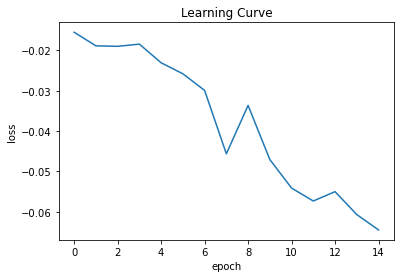

In [49]:
# Learning Curve
plt.figure()
plt.plot(hist.history['loss'])
plt.title('Learning Curve')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [67]:
result = model.evaluate(train_generator, steps=16)

16/16 [==============================] - 18s 1s/step - loss: -0.0686 - transformer_loss: -0.0980 - flow_loss: 0.0294


In [68]:
print('NCC: {:.4f}'.format(-result[0]))

NCC: 0.0686


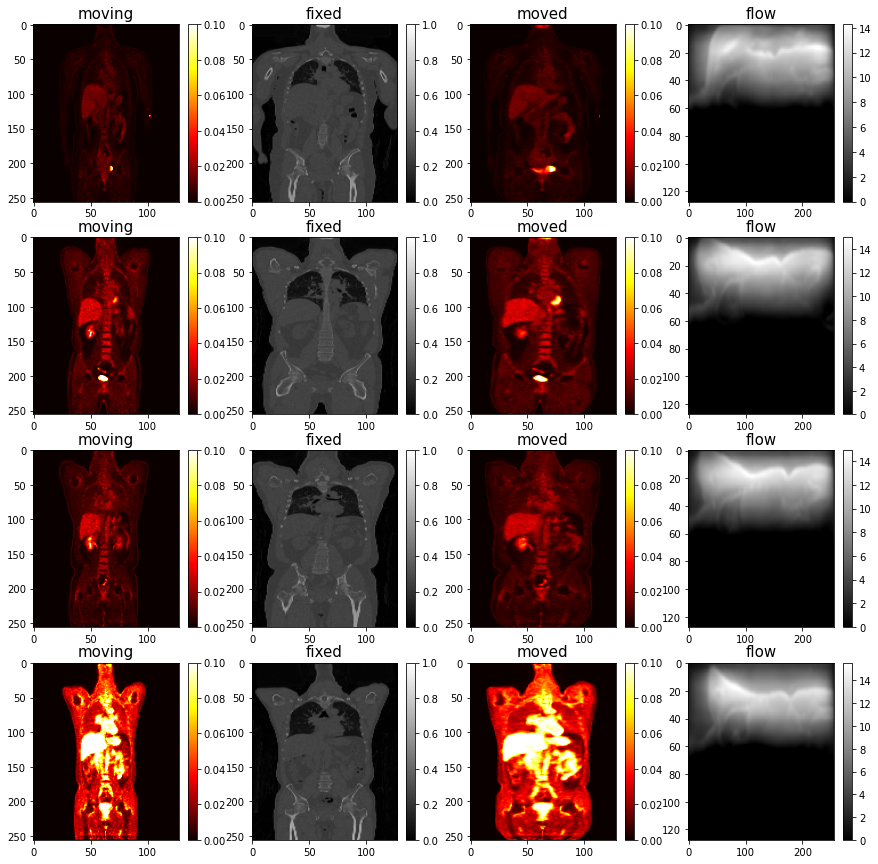

In [84]:
fig, axes = plt.figure(figsize=(15,15)), []
titles = ['moving', 'fixed', 'moved', 'flow']
cmap = [plt.cm.hot, plt.cm.gray, plt.cm.hot, plt.cm.gray]
vmax = [0.1, 1, 0.1, None]
for i in range(4):

    # Sample Validation
    val_input, _ = next(train_generator)
    val_pred = model.predict(val_input)

    # Visualization
    images = [img[0, 64, :, :, 0].T for img in val_input + [val_pred[0]]] + [val_pred[1][0, 64, :, :, 1]] 
    
    for j in range(4):
        axes.append(fig.add_subplot(4,4,4*i+j+1))
        axes[-1].set_title(titles[j], fontsize=15)
        clr = plt.imshow(images[j], aspect='auto', cmap=cmap[j], vmax=vmax[j], vmin=0)
        fig.colorbar(clr)

In [77]:
img1 = val_input[1]
img2 = val_pred[0]

print(np.mean(np.multiply((img1-np.mean(img1)),(img2-np.mean(img2))))/(np.std(img1)*np.std(img2)))

0.5164115234335853
